<a href="https://colab.research.google.com/github/suajeong52/CNN/blob/main/%EC%88%98%EC%95%84Resnet(%2Bval_relu)_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
NUM_CLASSES = 10

x_train = x_train.astype('float32')/255.
x_test  = x_test.astype('float32')/255.

y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

170508288/170498071 [==============================] - 4s 0us/step


In [3]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-aunyjyip
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-aunyjyip
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=60ed70fb3122a226caae4fc18f331f533e4e7603290f2341bf0f6738bf87c875
  Stored in directory: /tmp/pip-ephem-wheel-cache-xz85vvlw/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [4]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Layer, InputSpec, Activation, LeakyReLU
from tensorflow.keras.activations import sigmoid 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError 
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import add

from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
import os

In [7]:
from tensorflow.keras.models import load_model # 모델 저장하고 불러오는 방법

In [8]:
class CustomCallback(Callback):
    
    def __init__(self, run_folder, print_every_n_batches, initial_epoch, vae, ):
        self.epoch = initial_epoch
        self.run_folder = run_folder
        self.print_every_n_batches = print_every_n_batches
        self.vae = vae

    def on_batch_end(self, batch, logs={}):  
      a=0
    #  if batch % self.print_every_n_batches == 0:
    #    print(batch)
     #     self.model.predict()
     #     potential_by_cnn =  model.predict(X_test)


     #       z_new = np.random.normal(size = (1,self.vae.z_dim))
     #       reconst = self.vae.decoder.predict(np.array(z_new))[0].squeeze()

      #      filepath = os.path.join(self.run_folder, 'images', 'img_' + str(self.epoch).zfill(3) + '_' + str(batch) + '.jpg')
      #      if len(reconst.shape) == 2:
      #          plt.imsave(filepath, reconst, cmap='gray_r')
      #      else:
      #          plt.imsave(filepath, reconst)

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch += 1



def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        
        return new_lr

    return LearningRateScheduler(schedule)

In [9]:
weight_init = RandomNormal(mean=0., stddev=0.02)

def conv7s1(layer_input, filters, final):
  y = ReflectionPadding2D(padding =(3,3))(layer_input)
  y = Conv2D(filters, kernel_size=(7,7), strides=1, padding='valid', kernel_initializer = weight_init)(y)
  if final:
    y = sigmoid(y) 
  else: 
    y = LeakyReLU()(y)
    y = InstanceNormalization(axis = -1, center = False, scale = False)(y)

  return y

def downsample(layer_input,filters):
  y = Conv2D(filters, kernel_size=(3,3), strides=2, padding='same', kernel_initializer = weight_init)(layer_input)
  y = LeakyReLU()(y)
  y = InstanceNormalization(axis = -1, center = False, scale = False)(y)
  return y

def residual(layer_input, filters):
  shortcut = layer_input
  y = ReflectionPadding2D(padding =(1,1))(layer_input)
  y = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='valid', kernel_initializer = weight_init)(y)
  y = LeakyReLU()(y)
  y = InstanceNormalization(axis = -1, center = False, scale = False)(y)
  return add([shortcut, y])

def upsample(layer_input,filters):
  y = Conv2DTranspose(filters, kernel_size=(3, 3), strides=2, padding='same', kernel_initializer = weight_init)(layer_input)
  y = LeakyReLU()(y)
  y = InstanceNormalization(axis = -1, center = False, scale = False)(y)
  return y




In [10]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

In [11]:
gen_n_filters = 8

img = Input(shape=(32,32,3))

y = conv7s1(img, gen_n_filters, False)


y = downsample(y, gen_n_filters * 2)
for i in range(10):
  y = residual(y, gen_n_filters * 2)


y = downsample(y, gen_n_filters * 2)
for i in range(10):
  y = residual(y, gen_n_filters * 2)

y = Flatten()(y)

y = Dense(128, activation ='relu')(y)

output = Dense(10, activation = 'softmax')(y)

   
model = Model(img, output)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 reflection_padding2d (Reflecti  (None, 38, 38, 3)   0           ['input_1[0][0]']                
 onPadding2D)                                                                                     
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 8)    1184        ['reflection_padding2d[0][0]']   
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 8)    0           ['conv2d[0][0]']             

In [13]:
opt = Adam(learning_rate=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics= ['accuracy'])

In [15]:
history = model.fit(x_train, y_train, batch_size = 128, epochs = 30, shuffle=True, validation_split=0.1)

Epoch 1/30
352/352 [==============================] - 12s 33ms/step - loss: 1.7491 - accuracy: 0.3762 - val_loss: 1.5498 - val_accuracy: 0.4468
Epoch 2/30
352/352 [==============================] - 11s 30ms/step - loss: 1.4583 - accuracy: 0.4847 - val_loss: 1.3924 - val_accuracy: 0.5002
Epoch 3/30
352/352 [==============================] - 11s 30ms/step - loss: 1.2866 - accuracy: 0.5468 - val_loss: 1.2908 - val_accuracy: 0.5434
Epoch 4/30
352/352 [==============================] - 11s 30ms/step - loss: 1.1578 - accuracy: 0.5917 - val_loss: 1.2286 - val_accuracy: 0.5734
Epoch 5/30
352/352 [==============================] - 11s 30ms/step - loss: 1.0367 - accuracy: 0.6358 - val_loss: 1.1429 - val_accuracy: 0.5990
Epoch 6/30
352/352 [==============================] - 13s 37ms/step - loss: 0.9367 - accuracy: 0.6719 - val_loss: 1.0931 - val_accuracy: 0.6222
Epoch 7/30
352/352 [==============================] - 11s 30ms/step - loss: 0.8442 - accuracy: 0.7032 - val_loss: 1.0618 - val_accuracy:

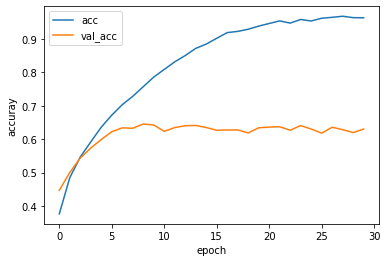

In [17]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.ylabel('accuray')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

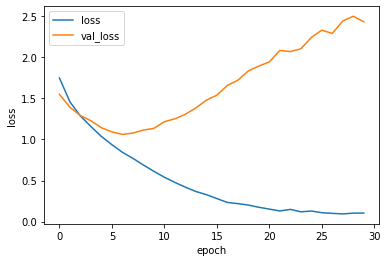

In [18]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [19]:
model.evaluate(x_test, y_test, batch_size=1000)

10/10 [==============================] - 1s 39ms/step - loss: 2.4848 - accuracy: 0.6134


[2.4848313331604004, 0.6133999824523926]